In [1]:

# import library
!pip install --upgrade -q transformers datasets evaluate accelerate optuna scikit-learn
import pandas as pd
import numpy as np
import os
import torch
import gc
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
from datasets import Dataset

set_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.

2025-10-15 14:06:52.193570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760537212.570943      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760537212.698667      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# LOAD DATA PREPROCESS
try:
    data_path = "/kaggle/input/sarcasm-preprocessed-4-versions/processed_data_sarcasm"
    df_train = pd.read_parquet(os.path.join(data_path, "train_processed_all_versions.parquet"))
    df_val = pd.read_parquet(os.path.join(data_path, "val_processed_all_versions.parquet"))
    df_test = pd.read_parquet(os.path.join(data_path, "test_processed_all_versions.parquet"))
    print(f"Jumlah data train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")
except Exception as e:
    print(f" Gagal memuat data. Error: {e}")

df_train.head()

Jumlah data train: 9881, val: 1411, test: 2824


,label,text_sw_norm,text_sw_nonorm,text_nosw_norm,text_nosw_nonorm
0,0,bilang chinese playing victim gasadar playing ...,bilang chinese playing victim gasadar playing ...,kamu bilang chinese playing victim tapi kamu g...,lo bilang chinese playing victim tapi lo gasad...
1,0,kadangkadang sampe mikir kayaknya buku mending...,kadangkadang sampe mikir kayaknya buku mending...,kadangkadang sampe aku mikir kayaknya buku beg...,kadangkadang sampe aku mikir kayaknya buku gin...
2,0,bukanya berduka mlh konspirasi,bukanya berduka mlh konspirasi,bukanya berduka mlh buat konspirasi sendiri,bukanya berduka mlh buat konspirasi sendiri
3,0,"atta halilintar pamer youtube dasar pamer, kay...","atta halilintar pamer youtube dasar pamer, kay...","atta halilintar pamer di youtube dasar pamer, ...","atta halilintar pamer di youtube dasar pamer, ..."
4,0,lokasinya kalimantan,lokasinya kalimantan,pasti lokasinya di kalimantan,pasti lokasinya di kalimantan


In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)

In [4]:
# KONFIGURASI EKSPERIMEN & FUNGSI METRIK 
MODEL_NAME = "indobenchmark/indobert-base-p1"
TEXT_COLUMNS = ['text_sw_norm', 'text_sw_nonorm', 'text_nosw_norm', 'text_nosw_nonorm']
initial_results = {}

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    TrainingArguments,
    Trainer,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc
    }

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
# LOOP EKSPERIMEN AWAL

for column in TEXT_COLUMNS:
    # konversi Pandas ke Hugging Face 
    train_dataset = Dataset.from_pandas(df_train[['label', column]])
    val_dataset = Dataset.from_pandas(df_val[['label', column]])

    train_dataset = train_dataset.rename_column("label", "labels")
    val_dataset = val_dataset.rename_column("label", "labels")
    
    # tokenisasi
    def tokenize_function(examples):
        return tokenizer(examples[column], padding="max_length", truncation=True, max_length=128)

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    
    # konfigurasi Pelatihan 
    BATCH_SIZE = 16
    
    training_args = TrainingArguments(
        output_dir=f'./results_{column}',
        num_train_epochs=3,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=True, 
        report_to="none"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics
    )
    trainer.train()
    
    # evaluasi & simpan hasil
    eval_metrics = trainer.evaluate(eval_dataset=tokenized_val)
    initial_results[column] = eval_metrics
      
    del model
    del trainer
    torch.cuda.empty_cache()
    gc.collect()

Map:   0%|          | 0/9881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1411 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.445400,0.463577,0.779589,0.735619,0.761119,0.779589,0.298379
2,0.343000,0.474224,0.782424,0.776252,0.772608,0.782424,0.391714
3,0.217700,0.580326,0.771793,0.763184,0.758664,0.771793,0.353364


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map:   0%|          | 0/9881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1411 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.441200,0.456368,0.783841,0.747571,0.764749,0.783841,0.323486
2,0.337600,0.476622,0.781006,0.775832,0.772456,0.781006,0.391949
3,0.209100,0.591356,0.771793,0.765730,0.761836,0.771793,0.363398


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map:   0%|          | 0/9881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1411 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.424200,0.432466,0.793055,0.772756,0.775385,0.793055,0.380225
2,0.306700,0.447028,0.800142,0.792859,0.789781,0.800142,0.435777
3,0.150600,0.555415,0.790928,0.785744,0.782585,0.790928,0.418682


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map:   0%|          | 0/9881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1411 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.420200,0.434384,0.797307,0.775520,0.780954,0.797307,0.390516
2,0.302200,0.446295,0.797307,0.790940,0.787757,0.797307,0.431359
3,0.149200,0.559212,0.791637,0.786593,0.783489,0.791637,0.421162


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [6]:
# ANALISIS & PENENTUAN MODEL PREPROCESS MANA YANG BAIK
print("Tabel Perbandingan Hasil Eksperimen Awal (diukur pakai set validasi):")
results_df = pd.DataFrame(initial_results).T.sort_values(by='eval_f1', ascending=False)
print(results_df[['eval_f1', 'eval_mcc', 'eval_accuracy', 'eval_loss']])

best_preprocessing_column = results_df.index[0]
print("\n" + "*"*50)
print(f"Preprocessing Terbaik: '{best_preprocessing_column}'")
print("*"*50)

Tabel Perbandingan Hasil Eksperimen Awal (diukur pakai set validasi):
                   eval_f1  eval_mcc  eval_accuracy  eval_loss
text_nosw_norm    0.792859  0.435777       0.800142   0.447028
text_nosw_nonorm  0.790940  0.431359       0.797307   0.446295
text_sw_norm      0.776252  0.391714       0.782424   0.474224
text_sw_nonorm    0.775832  0.391949       0.781006   0.476622

**************************************************
Preprocessing Terbaik: 'text_nosw_norm'
**************************************************


In [7]:
from transformers import Trainer, AutoModelForSequenceClassification
from datasets import Dataset
import numpy as np
from sklearn.metrics import classification_report, matthews_corrcoef

# LANGKAH VALIDASI: EVALUASI PADA TEST SET

best_preprocessing_column = 'text_nosw_norm' 
best_model_checkpoint = f'./results_{best_preprocessing_column}/checkpoint-927'
print("\nMemuat model terbaik dari checkpoint...")
model = AutoModelForSequenceClassification.from_pretrained(best_model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1") 

# test set
test_dataset = Dataset.from_pandas(df_test[['label', best_preprocessing_column]])
test_dataset = test_dataset.rename_column("label", "labels")

def tokenize_test_function(examples):
    return tokenizer(examples[best_preprocessing_column], padding="max_length", truncation=True, max_length=128)

tokenized_test = test_dataset.map(tokenize_test_function, batched=True)
eval_args = TrainingArguments(
    output_dir="./eval_temp",
    dataloader_num_workers=0,  
    report_to="none"
)
trainer_for_eval = Trainer(
    model=model,
    args=eval_args 
)

print("\nMelakukan prediksi pada TEST SET...")
test_predictions = trainer_for_eval.predict(tokenized_test)
test_preds_labels = np.argmax(test_predictions.predictions, axis=1)



Memuat model terbaik dari checkpoint...


Map:   0%|          | 0/2824 [00:00<?, ? examples/s]


Melakukan prediksi pada TEST SET...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [8]:
from sklearn.metrics import classification_report, matthews_corrcoef

print("Laporan Klasifikasi Indobert (text_nosw_norm) di Test Set:")
print(classification_report(tokenized_test["labels"], test_preds_labels, target_names=["Non-Sarkastik", "Sarkastik"]))

final_mcc = matthews_corrcoef(tokenized_test["labels"], test_preds_labels)
print(f"Matthews Correlation Coefficient (MCC) Final: {final_mcc:.4f}")

Laporan Klasifikasi Indobert (text_nosw_norm) di Test Set:
               precision    recall  f1-score   support

Non-Sarkastik       0.86      0.88      0.87      2118
    Sarkastik       0.61      0.55      0.58       706

     accuracy                           0.80      2824
    macro avg       0.73      0.72      0.73      2824
 weighted avg       0.79      0.80      0.80      2824

Matthews Correlation Coefficient (MCC) Final: 0.4515


Confusion Matrix Indobert (text_nosw_norm) Base:


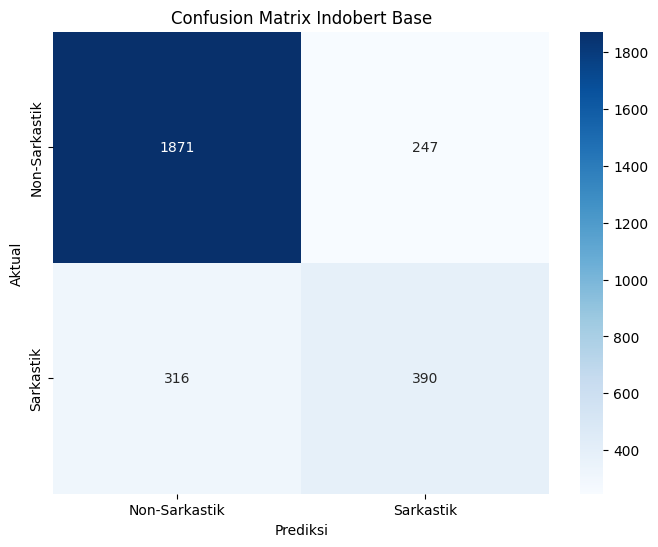

In [9]:
print("Confusion Matrix Indobert (text_nosw_norm) Base:")
cm = confusion_matrix(tokenized_test["labels"], test_preds_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Sarkastik", "Sarkastik"], yticklabels=["Non-Sarkastik", "Sarkastik"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Indobert Base")
plt.show()

In [10]:
print("Nama kolom yang tersedia di df_train:", df_train.columns.tolist())

Nama kolom yang tersedia di df_train: ['label', 'text_sw_norm', 'text_sw_nonorm', 'text_nosw_norm', 'text_nosw_nonorm']


In [11]:
print("Menganalisis duplikasi data antara train set dan test set...")

# Kita hanya perlu kolom teks dari DataFrame yang sudah di-load dan diperbaiki
train_texts = set(df_train['text_sw_norm'])
test_texts = set(df_test['text_sw_norm'])

# Cari irisan (intersection) antara kedua set
overlapping_texts = train_texts.intersection(test_texts)

# Hitung dan tampilkan hasilnya
num_overlap = len(overlapping_texts)
num_test = len(test_texts)
overlap_percentage = (num_overlap / num_test) * 100 if num_test > 0 else 0

print(f"Total komentar unik di test set: {num_test}")
print(f"Jumlah komentar di test set yang JUGA ADA di train set: {num_overlap}")
print(f"Persentase data test yang 'bocor' dari data train: {overlap_percentage:.2f}%")
print("-" * 50)

if num_overlap > 0:
    print("\nContoh 5 komentar yang tumpang tindih:")
    # Tampilkan 5 contoh komentar yang bocor
    for i, text in enumerate(list(overlapping_texts)[:5]):
        print(f"{i+1}. {text}")
else:
    print("Tidak ditemukan duplikasi data secara langsung.")

Menganalisis duplikasi data antara train set dan test set...
Total komentar unik di test set: 2821
Jumlah komentar di test set yang JUGA ADA di train set: 3
Persentase data test yang 'bocor' dari data train: 0.11%
--------------------------------------------------

Contoh 5 komentar yang tumpang tindih:
1. 
2. suka
3. tau
